In [1]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
from importlib import reload
import setGPU

setGPU: Setting GPU to: 0


In [62]:
import models.models as models
reload(models)
import utils.preprocessing as prepr
reload(prepr)

<module 'utils.preprocessing' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py'>

In [130]:
#Data Samples
DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'

TRAIN_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband'
filename_bg = DATA_PATH + TRAIN_NAME + '_parts/' + TRAIN_NAME + '_000.h5'
batch_size = 128
train_set_size = int((5*10e4//batch_size)*batch_size)

In [131]:
nodes_n, feat_sz, particles_bg, A_bg, A_tilde_bg = prepr.prepare_data(filename_bg,train_set_size,0,train_set_size+1)

# BG validation
VALID_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_EXT_sideband'
filename_bg_valid = DATA_PATH + VALID_NAME + '_parts/' + VALID_NAME + '_000.h5'
valid_set_size = int((10e4//batch_size)*batch_size)
_,_, particles_bg_valid, A_bg_valid, A_tilde_bg_valid = prepr.prepare_data(filename_bg,valid_set_size,0,valid_set_size+1)

Number of jets = 982833
Number of constituents (nodes) = 20
Number of features = 3


/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py:40: RuntimeWarning: divide by zero encountered in power
  D = np.nan_to_num(np.power(D,-0.5), posinf=0, neginf=0) # normalize (**-(1/2))


Number of jets = 196521
Number of constituents (nodes) = 20
Number of features = 3


In [65]:
#BG test
_,_, particles_bg_test, A_bg_test, A_tilde_bg_test = prepr.prepare_data(filename_bg,5000,train_set_size+1,train_set_size+5000)


Number of jets = 9849
Number of constituents (nodes) = 20
Number of features = 3


In [ ]:
#input_data_np_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/input/'
#input_data_np_name = 'QCD_training_data.npy'
#with open(input_data_np_dir+input_data_np_name, 'wb') as f:
#    np.save(f,particles_bg)
#    np.save(f,A_bg)
#    np.save(f,A_tilde_bg)

9984

In [66]:
#signal
SIG_MASS = '3.5'
SIG_NAME = 'RSGraviton_WW_NARROW_13TeV_PU40_'+SIG_MASS+'TeV_NEW'
filename_sig = DATA_PATH + SIG_NAME + '_parts/' + SIG_NAME + '_concat_001.h5'
_,_, particles_sig, A_sig, A_tilde_sig = prepr.prepare_data(filename_sig,5000,0,5000)

Number of jets = 9966
Number of constituents (nodes) = 20
Number of features = 3


In [67]:
print(particles_bg.shape, A_tilde_bg.shape, A_bg.shape)

(49920, 20, 3) (49920, 20, 20) (49920, 20, 20)


In [68]:
print((1e6//batch_size))
print(7812.0*batch_size)

7812.0
999936.0


# Plot features

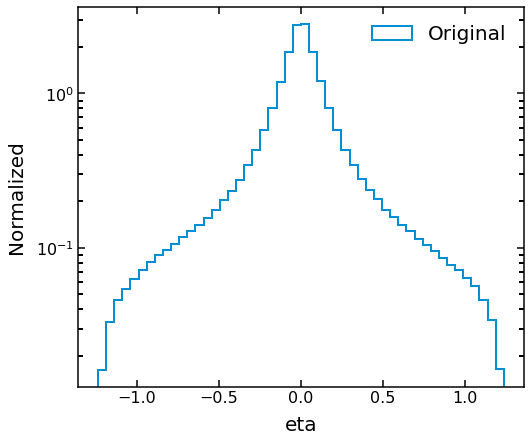

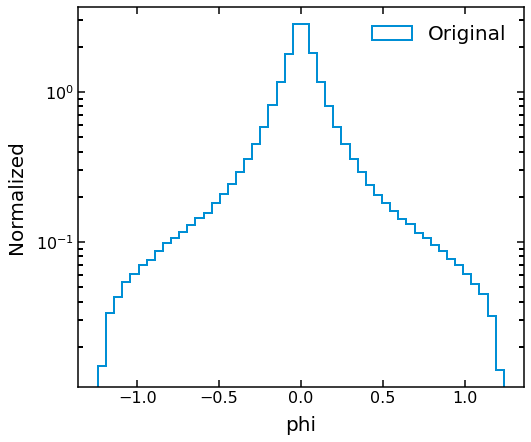

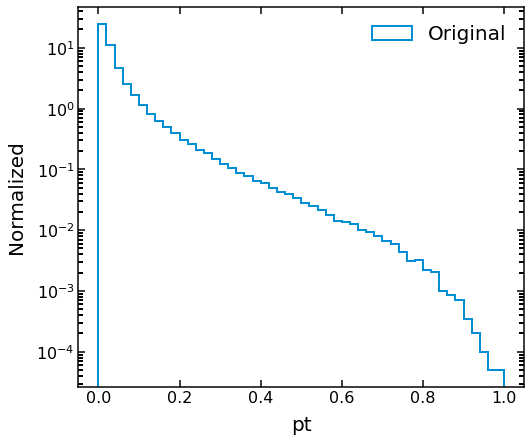

In [70]:
feats = 'eta,phi,pt'.split(',')
for i in range(0,3):
    xmin = np.quantile(particles_bg[:,:,i].flatten(),0.05)
    xmax = np.quantile(particles_bg[:,:,i].flatten(),0.98)
    plt.figure()
    plt.hist(particles_bg[:,:,i].flatten(), bins=50, label='Original', density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(loc='upper right')
    plt.semilogy()
    plt.show()

# Autoencoder

In [71]:
gnn = models.GraphAutoencoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh)
gnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), run_eagerly=True) 

Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_features (InputLa [(None, 20, 3)]      0                                            
__________________________________________________________________________________________________
encoder_input_adjacency (InputL [(None, 20, 20)]     0                                            
__________________________________________________________________________________________________
graph_convolution (GraphConvolu (None, 20, 6)        42          encoder_input_features[0][0]     
                                                                 encoder_input_adjacency[0][0]    
__________________________________________________________________________________________________
graph_convolution_1 (GraphConvo (None, 20, 8)        104         graph_convolution[0][

In [11]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, verbose=1),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)]
gnn.fit((particles_bg, A_tilde_bg), A_bg, epochs=50, batch_size=128, validation_split=0.25, callbacks=callbacks)

Epoch 1/50
38/38 [==============================] - 5s 120ms/step - val_loss: 0.4240
Epoch 2/50
38/38 [==============================] - 4s 116ms/step - val_loss: 0.4240
Epoch 3/50
38/38 [==============================] - 4s 113ms/step - val_loss: 0.4240
Epoch 4/50
38/38 [==============================] - 4s 111ms/step - val_loss: 0.4240
Epoch 5/50
38/38 [==============================] - 4s 116ms/step - val_loss: 0.4240
Epoch 6/50
38/38 [==============================] - ETA: 0s
Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
38/38 [==============================] - 4s 107ms/step - val_loss: 0.4240
Epoch 7/50
38/38 [==============================] - 4s 108ms/step - val_loss: 0.4240
Epoch 8/50
38/38 [==============================] - 4s 113ms/step - val_loss: 0.4240
Epoch 00008: early stopping


## Predict BG and Sig

In [12]:
z_sig, A_pred_sig = gnn((particles_sig, A_tilde_sig))
z_bg_test, A_pred_bg_test = gnn((particles_bg_test, A_tilde_bg_test))
loss_signal_gnn = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_sig, A_pred_sig), axis=(1,2)).numpy() #predicted adjecny, but not set to 0/1 yet
loss_bg_gnn = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_bg_test, A_pred_bg_test), axis=(1,2)).numpy()

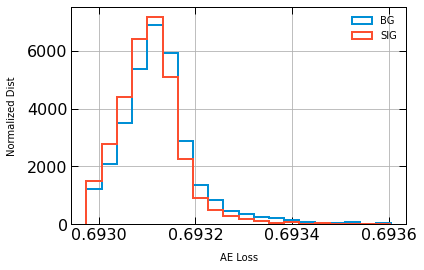

In [13]:
max_score = np.quantile(loss_signal_gnn,0.999)#,np.max(loss_bg_dist))
min_score = np.quantile(loss_bg_gnn,0.05)#,np.max(loss_bg_dist))
bins = 20
# plot BG
plt.figure()
plt.hist(loss_bg_gnn, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=2)
plt.hist(loss_signal_gnn, bins=bins, label='SIG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=2)
#plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Normalized Dist")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

# GVAE

In [22]:
gvae = models.GraphVariationalAutoencoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh)
gvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), run_eagerly=True) 

In [23]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, verbose=2),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2)] 
gvae.fit((particles_bg, A_tilde_bg), A_bg, epochs=30, batch_size=128, 
         validation_data = ((particles_bg_valid, A_tilde_bg_valid),A_bg_valid), callbacks=callbacks) 

Epoch 1/30
78/78 [==============================] - 4s 48ms/step - loss: 6.9207 - loss_reco: 3.9260 - loss_latent: 2.9947 - val_loss: 6.0321 - val_loss_reco: 3.4530 - val_loss_latent: 2.5792
Epoch 2/30
78/78 [==============================] - 3s 39ms/step - loss: 5.2177 - loss_reco: 3.0202 - loss_latent: 2.1975 - val_loss: 4.6389 - val_loss_reco: 2.7186 - val_loss_latent: 1.9203
Epoch 3/30
78/78 [==============================] - 3s 42ms/step - loss: 3.9764 - loss_reco: 2.3285 - loss_latent: 1.6479 - val_loss: 3.5655 - val_loss_reco: 2.0959 - val_loss_latent: 1.4695
Epoch 4/30
78/78 [==============================] - 3s 42ms/step - loss: 3.1077 - loss_reco: 1.8296 - loss_latent: 1.2781 - val_loss: 2.8835 - val_loss_reco: 1.7187 - val_loss_latent: 1.1648
Epoch 5/30
78/78 [==============================] - 3s 38ms/step - loss: 2.5127 - loss_reco: 1.4840 - loss_latent: 1.0288 - val_loss: 2.3514 - val_loss_reco: 1.3945 - val_loss_latent: 0.9569
Epoch 6/30
78/78 [===========================

In [16]:
z_sig, z_mean_sig, z_log_var_sig, A_pred_sig = gvae((particles_sig, A_tilde_sig))
z_bg_test,z_mean_bg_test, z_log_var_bg_test, A_pred_bg_test = gvae((particles_bg_test, A_tilde_bg_test))
loss_signal_gvae = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_sig, A_pred_sig), axis=(1,2)).numpy() #predicted adjecny, but not set to 0/1 yet
loss_bg_gvae = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_bg_test, A_pred_bg_test), axis=(1,2)).numpy()


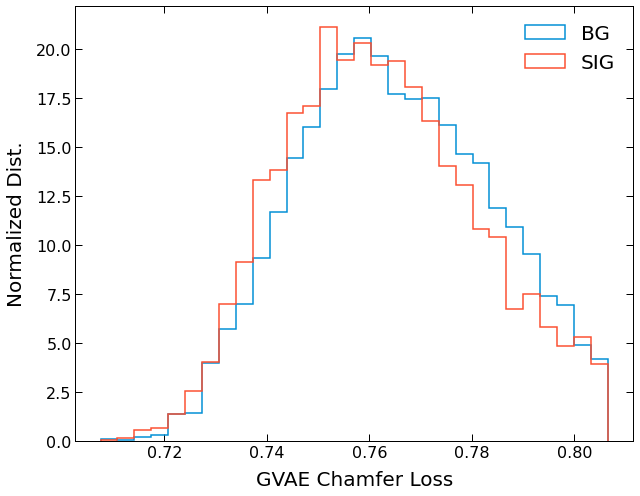

In [17]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

max_score = np.quantile(loss_signal_gvae,0.95)#,np.max(loss_bg_dist))
min_score = np.min(loss_bg_gvae)#,np.max(loss_bg_dist))
bins = 30
# plot BG
plt.figure()
plt.hist(loss_bg_gvae, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
plt.hist(loss_signal_gvae, bins=bins, label='SIG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
#plt.semilogy()
plt.xlabel("GVAE Chamfer Loss")
plt.ylabel("Normalized Dist.")
plt.legend(loc='upper right')
plt.show()

# GCN VAE

In [10]:
def threeD_loss_manual(inputs, outputs):
    distances = np.sum(np.subtract(inputs[:,:,np.newaxis,:],outputs[:,np.newaxis,:,:])**2, axis=-1)
    min_dist_to_inputs = np.min(distances,axis=1)
    min_dist_to_outputs = np.min(distances,axis=2)
    return np.sum(min_dist_to_inputs,axis=1) + np.sum(min_dist_to_outputs,axis=1)



In [132]:
import models.losses as losses
reload(losses)
import models.layers as layers
reload(layers)
import models.models as models
reload(models)
import utils.preprocessing as prepr
reload(prepr)


<module 'utils.preprocessing' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py'>

In [133]:
gcnvae = models.GCNVariationalAutoEncoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh,latent_dim=10,
                                          beta_kl=100,kl_warmup_time=5)
gcnvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), run_eagerly=True)


20
Model: "functional_75"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_features (InputLa [(None, 20, 3)]      0                                            
__________________________________________________________________________________________________
encoder_input_adjacency (InputL [(None, 20, 20)]     0                                            
__________________________________________________________________________________________________
graph_convolution_bias_74 (Grap (None, 20, 6)        24          encoder_input_features[0][0]     
                                                                 encoder_input_adjacency[0][0]    
__________________________________________________________________________________________________
graph_convolution_bias_75 (Grap (None, 20, 2)        14          graph_convolution_

In [134]:
#tf.keras.utils.plot_model(gcnvae, show_shapes=True)

In [ ]:
custom_callback = models.KLWarmupCallback()

checkpoint_filepath = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/weights_test.{epoch:02d}-{val_loss:.3f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3, verbose=2),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=2),
             custom_callback,
            model_checkpoint_callback] 
gcnvae.fit(particles_bg, A_tilde_bg, epochs=10, batch_size=128, 
           validation_data = ((particles_bg_valid, A_tilde_bg_valid)), callbacks=callbacks) 


Epoch 1/10
3906/3906 [==============================] - 110s 28ms/step - loss: 0.2042 - loss_reco: 0.1997 - loss_latent: 2.2262e-04 - beta_kl_warmup: 0.2000 - val_loss: 0.2070 - val_loss_reco: 0.2070 - val_loss_latent: 3.2219e-07
Epoch 2/10
3906/3906 [==============================] - 110s 28ms/step - loss: 0.1950 - loss_reco: 0.1949 - loss_latent: 1.0561e-07 - beta_kl_warmup: 0.4000 - val_loss: 0.2069 - val_loss_reco: 0.2069 - val_loss_latent: 3.6042e-08
Epoch 3/10
3906/3906 [==============================] - 113s 29ms/step - loss: 0.1948 - loss_reco: 0.1948 - loss_latent: 1.5327e-07 - beta_kl_warmup: 0.6000 - val_loss: 0.2073 - val_loss_reco: 0.2073 - val_loss_latent: 3.5134e-08
Epoch 4/10
3906/3906 [==============================] - 109s 28ms/step - loss: 0.1948 - loss_reco: 0.1947 - loss_latent: 1.4615e-07 - beta_kl_warmup: 0.8000 - val_loss: 0.2061 - val_loss_reco: 0.2061 - val_loss_latent: 1.8768e-07
Epoch 5/10
3906/3906 [==============================] - 115s 29ms/step - loss: 0

In [8]:

def threeD_loss_manual(inputs, outputs):
    distances = np.sum(np.subtract(inputs[:,:,np.newaxis,:],outputs[:,np.newaxis,:,:])**2, axis=-1)
    min_dist_to_inputs = np.min(distances,axis=1)
    min_dist_to_outputs = np.min(distances,axis=2)
    return np.sum(min_dist_to_inputs,axis=1) + np.sum(min_dist_to_outputs,axis=1)




In [20]:
loaded_1 = tf.keras.models.load_model(
    "output_model_saved_006", custom_objects={"GCNVariationalAutoEncoder": models.GCNVariationalAutoEncoder}
)


In [2]:
#Predict

#model = loaded_1
model = gcnvae

features_out_bg_test, z_bg_test, z_mean_bg_test, z_log_var_bg_test = model((particles_bg_test, A_tilde_bg_test))
features_out_bg_test = features_out_bg_test.numpy().astype('float32')
loss_bg = threeD_loss_manual(particles_bg_test.astype('float32'),features_out_bg_test)

features_out_sig, z_sig, z_mean_sig, z_log_var_sig = model((particles_sig, A_tilde_sig))
features_out_sig = features_out_sig.numpy().astype('float32')
loss_signal = threeD_loss_manual(particles_sig.astype('float32'),features_out_sig)

NameError: name 'gcnvae' is not defined

In [ ]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

max_score = np.quantile(loss_signal,0.99)#,np.max(loss_bg_dist))
min_score = np.min(loss_bg)#,np.max(loss_bg_dist))
bins = 30
# plot BG
plt.figure()
plt.hist(loss_bg, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
plt.hist(loss_signal, bins=bins, label='SIG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
#plt.semilogy()
plt.xlabel("VAE Chamfer Loss")
plt.ylabel("Normalized Dist.")
plt.legend(loc='upper right')
plt.show()

In [98]:
print(np.quantile(loss_bg,0.8),np.quantile(loss_signal,0.8))

5.999938583374024 7.0647268295288095


In [80]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../vande/')))
sys.path.append(os.path.abspath(os.path.join('../pofah/')))
sys.path.append(os.path.abspath(os.path.join('../sarewt/')))

In [81]:
import vande.analysis.analysis_roc as ar
reload(ar)

<module 'vande.analysis.analysis_roc' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py'>

In [82]:
#neg_class_losses = [loss_bg.tolist(),loss_bg_gnn.tolist(),loss_bg_gvae.tolist()]
#pos_class_losses = [loss_signal.tolist(),loss_signal_gnn.tolist(),loss_signal_gvae.tolist()]
neg_class_losses = [loss_bg.tolist()]
pos_class_losses = [loss_signal.tolist()]

/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")


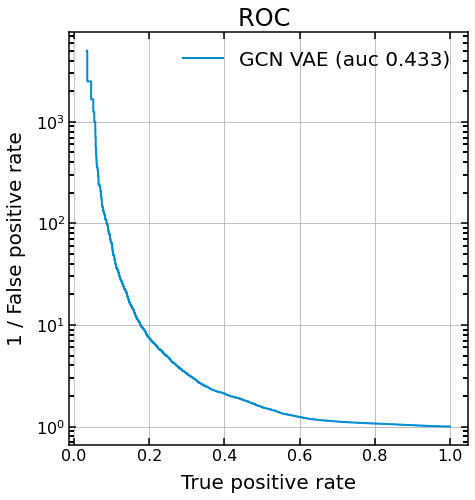

[0.43277340000000003]

In [83]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
#ar.plot_roc( neg_class_losses, pos_class_losses, legend=['GCN VAE','GAE','GVAE'], title='ROC ',
#            plot_name='ROC_text', fig_dir='figs/',log_x=False )
ar.plot_roc( neg_class_losses, pos_class_losses, legend=['GCN VAE'], title='ROC ',
            plot_name='ROC_gcnvae', fig_dir='figs/',log_x=False )



# Plot features 

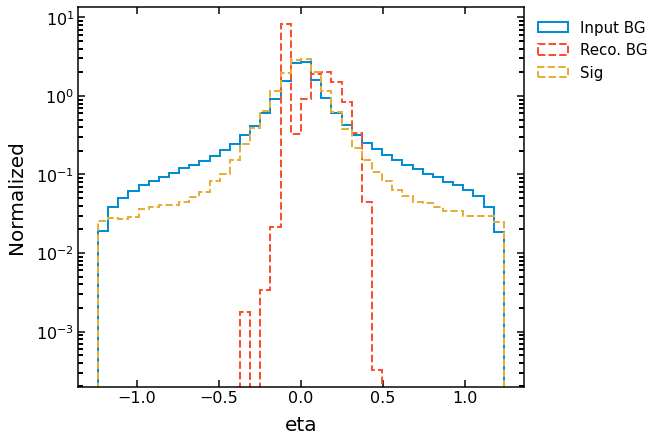

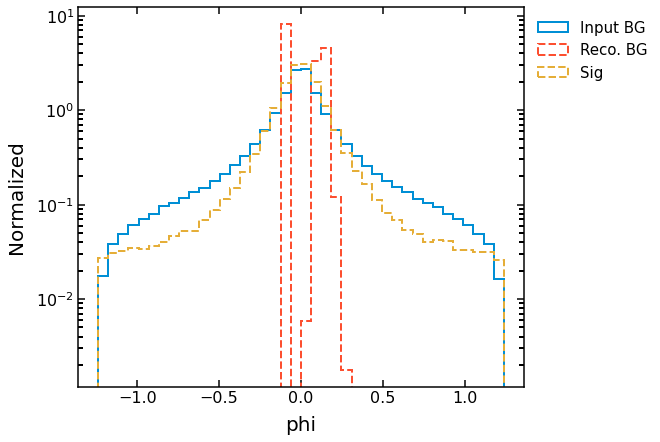

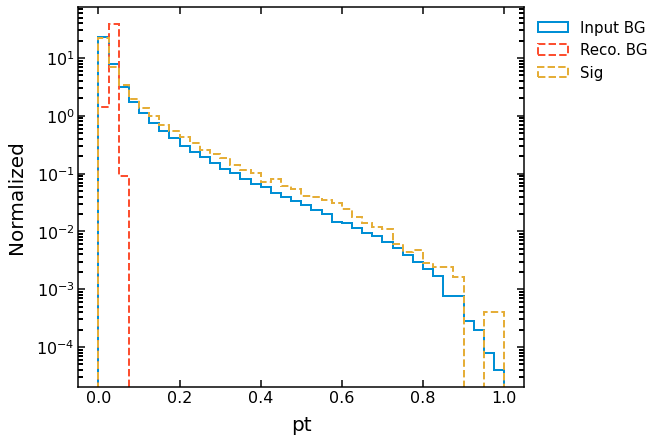

In [129]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
for i in range(0,len(feats)):
    #xmin = np.quantile(particles_bg[:,:,i].flatten(),0.)
    #xmax = np.quantile(particles_bg[:,:,i].flatten(),1)
    xmin = np.min([np.min(particles_bg[:,:,i].flatten()),np.min(features_out_bg_test[:,:,i].flatten())])
    xmax = np.max([np.max(particles_bg[:,:,i].flatten()),np.max(features_out_bg_test[:,:,i].flatten())])
    n_bins = 40
    plot_range = (xmin,xmax)
    plt.figure()
    _,bins,_ = plt.hist(particles_bg[:,:,i].flatten(), bins=n_bins, range = plot_range,label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    plt.hist(features_out_bg_test[:,:,i].flatten(), bins=bins,label='Reco. BG',linestyle='--', density=True, histtype='step', fill=False, linewidth=2)
    plt.hist(particles_sig[:,:,i].flatten(), bins=bins,label='Sig ',linestyle='--', density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    plt.semilogy()
    plt.show()